# Popularity of songs (song hotness, or "hotttnesss" ???)
In this section we are going to look at the million-song dataset and we are going to try to get the popularity of a song. The million-song dataset has a special structure. There are 26 folders A, B, C, ..., Z. Folder A has recursively 26 subfolders which have again 26 subfolders and so on and the last subfolders have a certain number of h5 files. Each of these h5 files contain all information about one track and the name of the file is simply the track id followed by the extension ".h5". 

Now the size of the dataset is pretty challenging since the compressed files A.tar.gz, B.tar.gz, ..., Z.tar.gz each have a size of approximately 7.5Gb. So we will start by taking a closer look at the A.tar.gz sample. For that we go to the cluster with ssh, we download A.tar.gz to our home folder and then we simply use scp on our computer to go grab that A.tar.gz file. Now, on our computer we unzip A.tar.gz and now we have a nice A folder containing the 26-th of all our songs !

In [23]:
import h5py
import os
import glob
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
from matplotlib import pyplot as plt
base_dir_data = r'../../'

%matplotlib inline

First we read one track with our `h5py` tool just to see where everything is located.

In [2]:
f = h5py.File(os.path.join(base_dir_data, "A/A/A/TRAAAAK128F9318786.h5"))

It is a good idea to open this file manually with [HDFView](https://support.hdfgroup.org/products/java/hdfview/) in order to inspect it before doing any code analysis. We see that it has 3 folders: analysis, metadata and musicbrainz. The analysis folder contains all the information about the musical instruments and how they're played. This is clearly the biggest folder. The musicbrainz doesn't seem to contain much. It could be useful if we decide to use the [MusicBrainz](https://musicbrainz.org/) website. Anyway, we are interested in the metadata folder and more precisely in the metadata/songs file. That file contains the "song_hotttnesss" (can't understand why 3 "t"s and 3 "s"s attribute which seems to be a value between 0 and 1 and this attribute corresponds to the popularity the song. So let's get it !

In [5]:
metadata_songs = f["metadata/songs"]

In [19]:
list(metadata_songs.attrs.items())

[('CLASS', b'TABLE'),
 ('VERSION', b'2.6'),
 ('TITLE', b'table of metadata for one song'),
 ('FIELD_0_NAME', b'analyzer_version'),
 ('FIELD_1_NAME', b'artist_7digitalid'),
 ('FIELD_2_NAME', b'artist_familiarity'),
 ('FIELD_3_NAME', b'artist_hotttnesss'),
 ('FIELD_4_NAME', b'artist_id'),
 ('FIELD_5_NAME', b'artist_latitude'),
 ('FIELD_6_NAME', b'artist_location'),
 ('FIELD_7_NAME', b'artist_longitude'),
 ('FIELD_8_NAME', b'artist_mbid'),
 ('FIELD_9_NAME', b'artist_name'),
 ('FIELD_10_NAME', b'artist_playmeid'),
 ('FIELD_11_NAME', b'genre'),
 ('FIELD_12_NAME', b'idx_artist_terms'),
 ('FIELD_13_NAME', b'idx_similar_artists'),
 ('FIELD_14_NAME', b'release'),
 ('FIELD_15_NAME', b'release_7digitalid'),
 ('FIELD_16_NAME', b'song_hotttnesss'),
 ('FIELD_17_NAME', b'song_id'),
 ('FIELD_18_NAME', b'title'),
 ('FIELD_19_NAME', b'track_7digitalid'),
 ('FIELD_0_FILL', b''),
 ('FIELD_1_FILL', 0),
 ('FIELD_2_FILL', 0.0),
 ('FIELD_3_FILL', 0.0),
 ('FIELD_4_FILL', b''),
 ('FIELD_5_FILL', 0.0),
 ('FIELD_

So here we see that the "FIELD_16_NAME" corresponds to the song hotness attribute. let's look with closer details:

In [23]:
metadata_songs.value

array([ (b'', 324573,  0.63990252,  0.46131834, b'ARJNIUY12298900C91',  nan, b'',  nan, b'6ae6a016-91d7-46cc-be7d-5e8e5d320c54', b'Adelitas Way', 166043, b'', 0, 0, b'Adelitas Way', 497103,  0.73337162, b'SOBLFFE12AF72AA5BA', b'Scream', 5504670)],
      dtype=[('analyzer_version', 'S32'), ('artist_7digitalid', '<i4'), ('artist_familiarity', '<f8'), ('artist_hotttnesss', '<f8'), ('artist_id', 'S32'), ('artist_latitude', '<f8'), ('artist_location', 'S1024'), ('artist_longitude', '<f8'), ('artist_mbid', 'S40'), ('artist_name', 'S1024'), ('artist_playmeid', '<i4'), ('genre', 'S1024'), ('idx_artist_terms', '<i4'), ('idx_similar_artists', '<i4'), ('release', 'S1024'), ('release_7digitalid', '<i4'), ('song_hotttnesss', '<f8'), ('song_id', 'S32'), ('title', 'S1024'), ('track_7digitalid', '<i4')])

Indeed, we see that the song hotness is the element at index 16 of the `value` attribute:

In [24]:
metadata_songs.value[0][16]

0.7333716199617285

Now let's try to generalize this to all of A folder:

In [46]:
def count_all_files(basedir, ext='.h5'):
    hotness = []
    track_ids = []
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        for f in files:
            h5_file = h5py.File(str(f))
            song_hotttnesss = h5_file["metadata/songs"].value[0][16]
            track_ids.append(f.split("/")[-1].split(".")[0])
            hotness.append(song_hotttnesss)
    return pd.DataFrame(data={"id" : track_ids, "hotttnesss": hotness})

song_hotness_A = count_all_files(r'../../A/')

That's it ! We now have a nice pandas frame containing the track ids with the hotness of the corresponding song:

In [47]:
song_hotness_A.head()

,hotttnesss,id
0,0.000000,TRARRQU128F427DAD3
1,0.524822,TRARRAO128F145D072
2,NaN,TRARRWA128F42A0195
3,0.204543,TRARRYB128F426BC39
4,NaN,TRARRNK12903D0C0DA


If you are not convinced, you can take rows at random and go see in the h5 file if the value you have corresponds to the value "song_hotttnesss" in the h5 file. Now we will need a fast way to find a song given its track id:

In [48]:
song_hotness_A = song_hotness_A.set_index("id")

In [30]:
song_hotness_A.head()

,hotttnesss
id,
TRARRQU128F427DAD3,0.000000
TRARRAO128F145D072,0.524822
TRARRWA128F42A0195,NaN
TRARRYB128F426BC39,0.204543
TRARRNK12903D0C0DA,NaN


Of course, we don't want to lose this so:

In [31]:
song_hotness_A.to_csv(os.path.join(base_dir_data, "csv_hotness_files/A_hotness.csv"))

That's it ! We have our csv data for A. But now we have 25 other folders to process and there's no way we are going to download each manually on our small computers (moreover it takes much time to download them). So this is what we are doing. We are creating a bash script for processing all the files directly on the cluster:

```bash
#!/bin/bash

set -e

declare -a filenames=("B" "C" "D" "E" "F" "G" "H" "I" "J" "K" "L" "M" "N" "O" "P"
            "Q" "R" "S" "T" "U" "V" "W" "X" "Y" "Z")

for letter in "${filenames[@]}"
do
    eval "hadoop fs -getmerge /datasets/million-song/$letter.tar.gz ~/$letter.tar.gz"
    eval "tar -zxvf $letter.tar.gz"
    eval "rm $letter.tar.gz"
    eval "python script_h5_to_csv.py $letter"
    eval "rm -r $letter"
done
```

So in short, we copy the hdfs file to our local folder, we unzip it, we remove the compressed version, we process it and get the csv the same way we did it for A and, finally, we remove the folder (yes I am too lazy to go search how we convert ASCII numbers to characters in bash so I created the alphabet array manually). The "script_h5_to_csv.py" contains the following code (which is the same we did for A above in the notebook):

```python
import os
import glob
import sys
import pandas as pd
import h5py

def count_all_files(basedir, ext='.h5'):
    hotness = []
    track_ids = []
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        for f in files:
            h5_file = h5py.File(str(f))
            song_hotttnesss = h5_file["metadata/songs"].value[0][16]
            track_ids.append(f.split("/")[-1].split(".")[0])
            hotness.append(song_hotttnesss)
    return pd.DataFrame(data={"id" : track_ids, "hotttnesss": hotness})

song_hotness_A = count_all_files(sys.argv[1])
song_hotness_A.to_csv("{}_hotness.csv".format(sys.argv[1]))
```

We use [tmux](https://github.com/tmux/tmux/wiki) to let the script run during the night and that's it, We have our csv files containing the hotness for our entire set of one million songs !

Now we want to combine this information with the [Musixmatch](https://www.musixmatch.com/fr) lyrics dataset because we need the lyrics if we want to do any processing. This is why we are going to keep only the tracks for which we have the lyrics. So let's get all those tracks:

In [2]:
conn = sqlite3.connect("../../mxm_dataset.db.1")
cursor = conn.cursor()
cursor.execute("SELECT DISTINCT track_id FROM lyrics ORDER BY track_id;")
track_ids = cursor.fetchall()
cursor.close()
track_ids[:5]

[('TRAAAAV128F421A322',),
 ('TRAAABD128F429CF47',),
 ('TRAAAED128E0783FAB',),
 ('TRAAAEF128F4273421',),
 ('TRAAAEW128F42930C0',)]

We read all hotness csv files into one big dataframe:

In [6]:
all_csv_hotness_files = glob.glob(os.path.join(base_dir_data, "csv_hotness_files/*_hotness.csv"))

list_all_frames = []
for csv in all_csv_hotness_files:
    df = pd.read_csv(csv)
    list_all_frames.append(df[["id", "hotttnesss"]])

song_hotness = pd.concat(list_all_frames)

In [7]:
song_hotness.shape

(1000000, 2)

That's it, we have one million songs ! Now let's just save this dataframe:

In [50]:
song_hotness.to_csv(os.path.join(base_dir_data, "csv_hotness_files/hotness.csv"))

Now we set the index:

In [8]:
song_hotness = song_hotness.set_index("id")

And finally, we take only the songs where we have the lyrics in the Musixmatch dataset:

In [14]:
def get_lyrics_only_hotness():
    result = pd.DataFrame(columns=["hotness"])
    for i in tqdm(range(len(track_ids))):
        track_id = track_ids[i][0]
        if track_id in song_hotness.index:
            hotness = song_hotness.loc[track_id]["hotttnesss"]
            result.loc[track_id] = [hotness]
    return result

song_hotness_lyrics = get_lyrics_only_hotness()

100%|██████████| 237662/237662 [2:19:48<00:00, 28.33it/s]


Wow ! Lasted more than 2 hours on a laptop. Probably should have done it on the cluster (or optimized it a little bit) We can't lose this so let's save it:

In [15]:
song_hotness_lyrics.to_csv(os.path.join(base_dir_data, "csv_hotness_files/hotness_lyrics.csv"))

Now we have our dataframe with the popularity (hotness) for all songs where we have lyrics:

In [18]:
song_hotness_lyrics.head()

,hotness
TRAAAAV128F421A322,0.481694
TRAAABD128F429CF47,NaN
TRAAAED128E0783FAB,NaN
TRAAAEF128F4273421,NaN
TRAAAEW128F42930C0,0.407902


Looking at the data we see that there are a lot of NaN values (songs for which the popularity was not measured). Let's just describe the frame:

In [19]:
song_hotness_lyrics.describe()

,hotness
count,170573.000000
mean,0.475753
std,0.209909
min,0.000000
25%,0.360371
50%,0.508289
75%,0.621942
max,1.000000


We see that the min is 0 and the max is 1, which indicates that we didn't do mistakes and that the dataset is pretty clean (there are no strange negative or greater than 1 values). We also see that we have 170573 "usable" datapoints, i.e. songs where we have the hotness value and the lyrics for further offensiveness analysis. On the one hand, that's less than 20% of the million songs but one the other it is still 170 thousands which makes quite a lot of data ! Let's plot the histograms here:

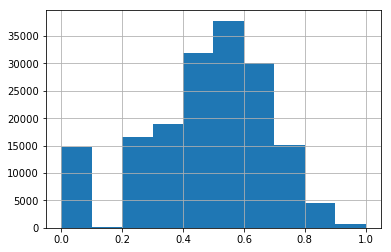

In [24]:
song_hotness_lyrics.hotness.hist()

Seems to look like a gaussian, except for these 0 values:

In [27]:
print("There are {} songs with hotness 0".format(song_hotness_lyrics[song_hotness_lyrics["hotness"] == 0].shape[0]))

There are 14756 songs with hotness 0


That makes almost 15000 songs for which we are somehow "unsure" about. Are those really songs with 0 popularity ?! Maybe they really didn't touch anyone or very few people. But let's look at the bright side: even if we cut them out in our analysis, we are still left with approximately 155000 songs for which we know the popularity value and the lyrics. But we still have to decide what we will do with these 15000 songs, will we keep them or exclude them ? Maybe we will keep them and treat them separately also. 

Anyway, Million Song and Echo Nest have our back covered: we can use another popularity measure which is the play count ! But this value is present in [another dataset](https://labrosa.ee.columbia.edu/millionsong/tasteprofile). If this doesn't work work we might also use the [Yahoo ratings dataset](https://labrosa.ee.columbia.edu/millionsong/pages/tasks-demos#yahoodata) but this one is for artist rating more than song rating so we should be careful if we decide to include it too. So let's proceed with Taste Profile !